# Assignment 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("StressDetection.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89825 entries, 0 to 89824
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  89825 non-null  int64  
 1   HR          89825 non-null  float64
 2   Time        89825 non-null  int64  
 3   ID          89825 non-null  object 
 4   BVP         89825 non-null  float64
 5   TEMP        89825 non-null  float64
 6   EDA         89825 non-null  float64
 7   ACC         89825 non-null  float64
 8   Stress      89825 non-null  float64
 9   IBI         89825 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [4]:
data = data.drop('Unnamed: 0', axis=1)

In [5]:
#Change Time column to Date-Time object
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [6]:
data.shape

(89825, 9)

In [7]:
data.describe()

,HR,BVP,TEMP,EDA,ACC,Stress,IBI
count,89825.000000,89825.000000,89825.000000,89825.000000,89825.000000,89825.000000,89825.000000
mean,79.686176,6.980644,30.870907,0.326144,37.119932,0.438018,0.070580
std,12.213275,8.894273,2.512872,0.291061,2.416455,0.496146,0.056514
min,49.000000,-0.050000,24.630000,0.000000,22.420229,0.000000,0.000000
25%,71.170000,0.000000,30.030000,0.138375,36.583228,0.000000,0.027549
50%,77.980000,3.015000,30.950000,0.228063,36.896237,0.000000,0.062500
75%,86.650000,11.460000,32.640000,0.480766,37.324570,1.000000,0.101562
max,141.080000,48.150000,34.910000,1.664104,82.823105,1.000000,0.562500


Each feature has different values as it is recorded in different units.

# Section 1: Visualizations

Plot bar chart stress and non-stress periods

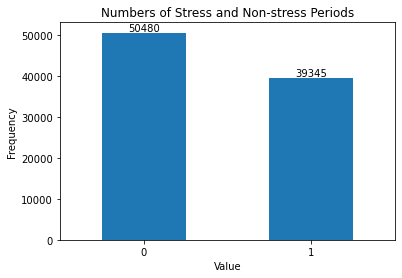

In [5]:
#Count values of 0 and 1
value_counts = data['Stress'].value_counts()

ax = value_counts.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Numbers of Stress and Non-stress Periods')
plt.xticks(rotation=0)

#Add count values to each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()

We can see that the stress and non-stress periods are semi-balanced. The stress period is 77.91% of the non-stress period.

Plot HR, BVP, TEMP, EDA, and ACC over period of time for participant 30

In [6]:
#Filter Data for ID S30
S30 = data[data['ID'] == 'S30']

In [7]:
#Create list of features
features = ['HR', 'BVP', 'TEMP', 'EDA', 'ACC', 'IBI']

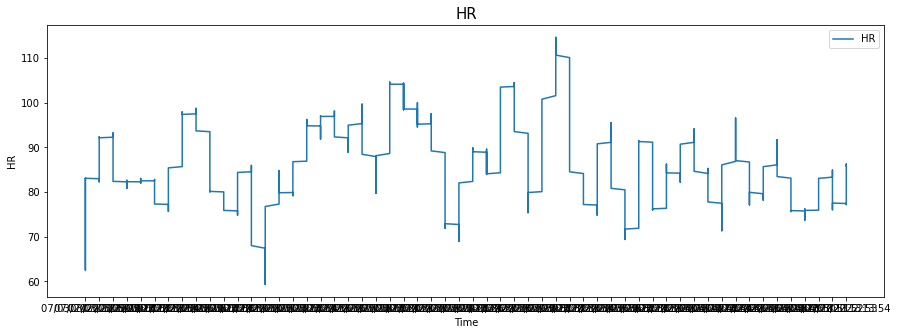

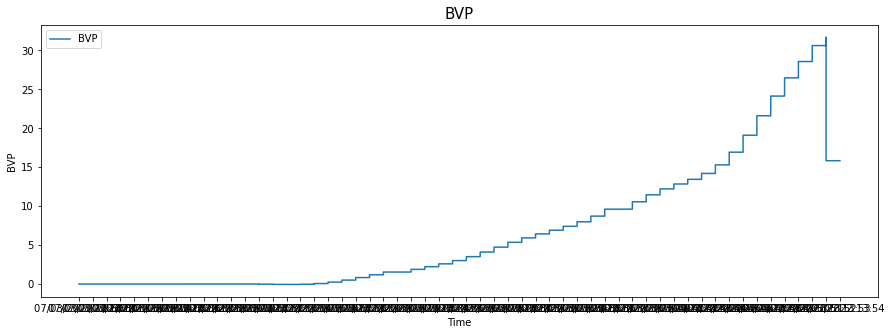

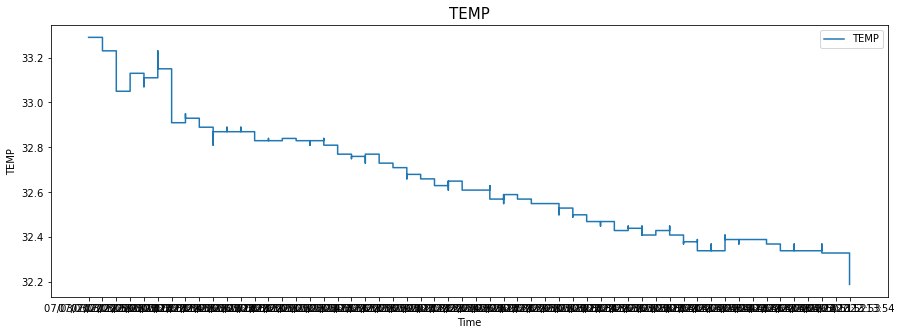

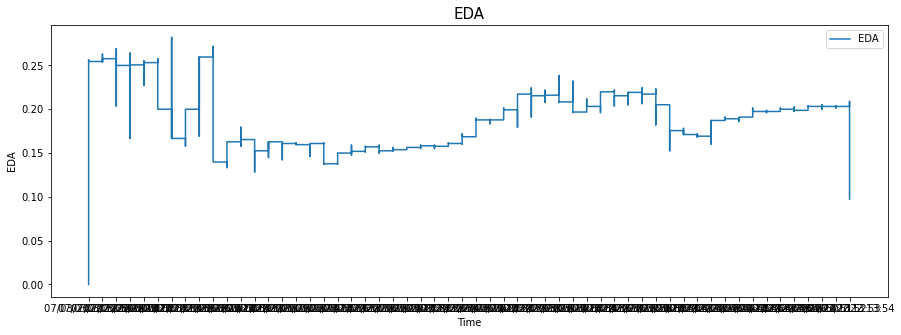

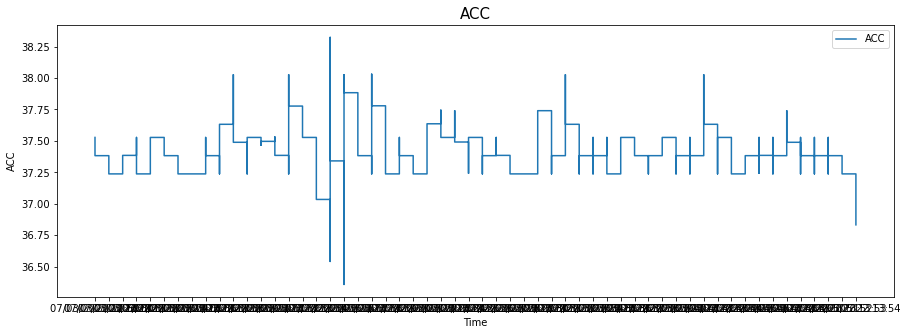

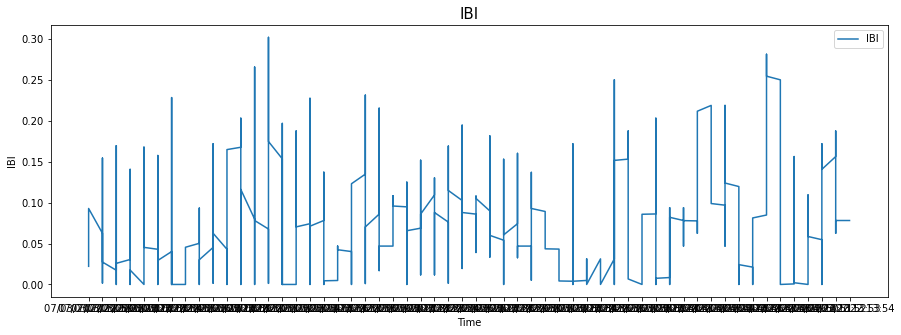

In [9]:
#Iterate through list and create plots
for i in features:
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(S30['Time'], S30[i], label=i)
    ax.set_xlabel('Time')
    ax.set_ylabel(i)
    ax.set_title(f"{i}", size=15)
    ax.legend()
    plt.show()

Create heatmap to see correlations. There is no signs of multicollinearity.

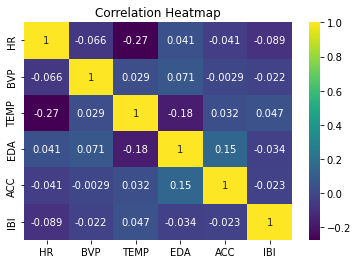

In [9]:
import seaborn as sns

correlation = data[features].corr()
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

Create box plot to see distribution of the data

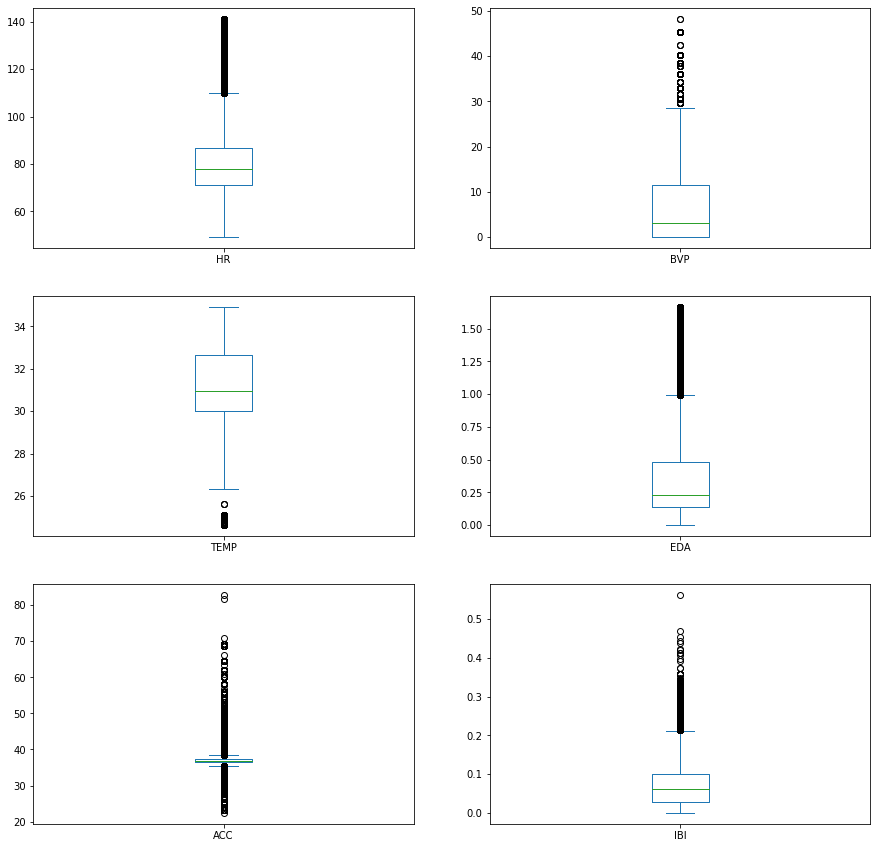

In [10]:
#Create box plot for features
features = ['HR', 'BVP', 'TEMP', 'EDA', 'ACC', 'IBI']

data[features].plot(kind='box', subplots=True, layout=(3, 2), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

# Important Features

In [5]:
X = data.drop(['Stress', 'Time', 'ID'], axis=1)
y = data[['Stress']]

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
#Create and fit random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=511)
random_forest.fit(X, np.ravel(y))

RandomForestClassifier(random_state=511)

In [8]:
#Get features according to feature importances that build up a decision tree
features_scores = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)

In [9]:
features_scores

BVP     0.446154
TEMP    0.151160
EDA     0.148726
ACC     0.108063
HR      0.099817
IBI     0.046079
dtype: float64

BVP has the highest contribution to stress.

# Section 2: Prepare Data

# 2.1 Create Lag Features

Each feature has different scale. Convert them with standardscaler to normalize them.

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
#Create list of columns that needed to be transformed
columns = ['HR', 'BVP', 'TEMP', 'EDA', 'ACC', 'IBI']

#Initiate standardscaler
scaler = StandardScaler()

# Fit and transform features
scaled_columns = scaler.fit_transform(data[columns])

In [13]:
#Replace the original columns with the scaled columns
data[columns] = scaled_columns

In [14]:
def create_lag_features(data, lag):
    lag_data = pd.DataFrame()
    unique_ids = data['ID'].unique()

    for unique_id in unique_ids:
        id_data = data[data['ID'] == unique_id].copy()
        id_cols = id_data.columns.tolist()

        for col in id_cols:
            if col not in ['ID', 'Time', 'Stress']:
                for l in range(1, lag + 1):
                    id_data[col + '_lag_' + str(l)] = id_data[col].shift(l)

        lag_data = pd.concat([lag_data, id_data], ignore_index=True)

    return lag_data


Input data[['BVP', 'TEMP', 'EDA', 'ID', 'Time', 'Stress']] for selected features random forest model and for creating different lags input number (in seconds).

In [15]:
#Get lag data
lag_data = create_lag_features(data , 15)

In [16]:
#After creating lags, there will be missing values. I drop the NAs
lag_data = lag_data.dropna()

# 2.2 Split Data

Create function that will split data into train and test sets by considering ID and Time. This is to make sure that the data of each participant is added to both sets.

In [17]:
def split_data_by_id(data, split_ratio):
    unique_ids = data['ID'].unique()

    train_data_list = []
    test_data_list = []

    for unique_id in unique_ids:
        id_data = data[data['ID'] == unique_id]
        split_index = int(len(id_data) * split_ratio)

        id_train_data = id_data.iloc[:split_index]
        id_test_data = id_data.iloc[split_index:]

        train_data_list.append(id_train_data)
        test_data_list.append(id_test_data)

    train_data = pd.concat(train_data_list, ignore_index=True)
    test_data = pd.concat(test_data_list, ignore_index=True)

    return train_data, test_data

In [18]:
train_data, test_data = split_data_by_id(lag_data, 0.8)

In [19]:
#Get train and test sets for features and target variables
X_train = train_data.drop(['Stress', 'Time', 'ID'], axis=1)
X_test = test_data.drop(['Stress', 'Time', 'ID'], axis=1)
y_train = train_data[['Stress']]
y_test = test_data[['Stress']]

# Section 3: Analysis

Next, I will use Random Forest, Support Vector Machine (SVM), Logistic Regression, and KNN to see whether there is the difference between stress and non-stress periods.

# 3.1 Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

The data is multivariate time-series data. The values from previous time may have impact on the current value. In this case, I will to train random forest model with different lags. 

Set lag = 30.

In [14]:
rf_lag30 = RandomForestClassifier(n_estimators=100, random_state=511)
rf_lag30.fit(X_train, np.ravel(y_train))
y_pred_lag30 = rf_lag30.predict(X_test)

In [17]:
accuracy_lag30 = accuracy_score(y_test, y_pred_lag30)
print(accuracy_lag30)

0.4275293193423489


Set lag = 10.

In [22]:
rf_lag10 = RandomForestClassifier(n_estimators=100, random_state=511)
rf_lag10.fit(X_train, np.ravel(y_train))
y_pred_lag10 = rf_lag10.predict(X_test)

In [23]:
accuracy_lag10 = accuracy_score(y_test, y_pred_lag10)
print(accuracy_lag10)

0.45388092182355894


Set lag = 15, which means taking values from 15 seconds in to consideration. 15 seconds create highest accuracy rate. First, I will try RF without adding any argument.

In [19]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=511)
rf1.fit(X_train, np.ravel(y_train))
y_pred_rf1 = rf1.predict(X_test)

In [20]:
accuracy_rf1 = accuracy_score(y_test, y_pred_rf1)
print(accuracy_rf1)

0.4940210102816272


In [21]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

         0.0       0.54      0.56      0.55      9945
         1.0       0.43      0.41      0.42      7951

    accuracy                           0.49     17896
   macro avg       0.49      0.49      0.49     17896
weighted avg       0.49      0.49      0.49     17896



In [22]:
cm1 = confusion_matrix(y_test, y_pred_rf1)
print(cm1)

[[5585 4360]
 [4695 3256]]


In [23]:
#Calculate False Negative rate
FN = cm1[1][0]
TP = cm1[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.5904917620425104


Second, try to use balanced class weight to add more weight on stress period.

In [83]:
#Try to adjust class weight to give more weight on stress period
rf2 = RandomForestClassifier(class_weight='balanced', random_state=511)
rf2.fit(X_train, np.ravel(y_train))
y_pred_rf2 = rf2.predict(X_test)

In [84]:
accuracy_rf2 = accuracy_score(y_test, y_pred_rf2)
print(accuracy_rf2)

0.5013969602145731


In [85]:
print(classification_report(y_test, y_pred_rf2))

              precision    recall  f1-score   support

         0.0       0.54      0.71      0.61      9945
         1.0       0.40      0.24      0.30      7951

    accuracy                           0.50     17896
   macro avg       0.47      0.48      0.46     17896
weighted avg       0.48      0.50      0.47     17896



In [99]:
cm2 = confusion_matrix(y_test, y_pred_rf2)
print(cm2)

[[7065 2880]
 [6043 1908]]


In [100]:
#Calculate False Negative rate
FN = cm2[1][0]
TP = cm2[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.7600301848824047


Third, create samples for stress period to make the stress and non-stress periods become more balance.

In [98]:
#Create synthetic sample for stress period
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=511)
X_resampled, y_resampled = sm.fit_resample(X_train, np.ravel(y_train))

rf3 = RandomForestClassifier(n_estimators=100, random_state=511)
rf3.fit(X_resampled, y_resampled)
y_pred_rf3 = rf3.predict(X_test)

In [101]:
accuracy_rf3 = accuracy_score(y_test, y_pred_rf3)
print(accuracy_rf3)

0.4927916852928029


In [102]:
print(classification_report(y_test, y_pred_rf3))

              precision    recall  f1-score   support

         0.0       0.53      0.71      0.61      9945
         1.0       0.38      0.23      0.28      7951

    accuracy                           0.49     17896
   macro avg       0.46      0.47      0.45     17896
weighted avg       0.47      0.49      0.46     17896



In [103]:
cm3 = confusion_matrix(y_test, y_pred_rf3)
print(cm3)

[[7019 2926]
 [6151 1800]]


In [104]:
#Calculate False Negative rate
FN = cm3[1][0]
TP = cm3[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.7736133819645328


Fourth, reduce decision threshold so that the model is more sensitive to predict positive class. This method effectively prevent False Negative.

In [115]:
#Adjust decision threshold to prevent False Negatives
rf4 = RandomForestClassifier(n_estimators=100, random_state=511)
rf4.fit(X_train, np.ravel(y_train))

y_pred_proba = rf4.predict_proba(X_test)
threshold = 0.4
y_pred_rf4 = (y_pred_proba[:, 1] >= threshold).astype(int)

In [116]:
accuracy_rf4 = accuracy_score(y_test, y_pred_rf4)
print(accuracy_rf4)

0.46764640143048725


In [117]:
print(classification_report(y_test, y_pred_rf4))

              precision    recall  f1-score   support

         0.0       0.54      0.31      0.39      9945
         1.0       0.44      0.67      0.53      7951

    accuracy                           0.47     17896
   macro avg       0.49      0.49      0.46     17896
weighted avg       0.49      0.47      0.45     17896



In [118]:
cm4 = confusion_matrix(y_test, y_pred_rf4)
print(cm4)

[[3062 6883]
 [2644 5307]]


In [119]:
#Calculate False Negative rate
FN = cm4[1][0]
TP = cm4[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.3325367878254308


Fifth, I will try to use random forest for top 3 important features: BVP, TEMP, and EDA. The accuracy rate slightly drops from 0.494 to 0.49 means that these 3 features are important for classification. However, it worsens the stress prediction.

In [60]:
rf5 = RandomForestClassifier(n_estimators=100, random_state=511)
rf5.fit(X_train, np.ravel(y_train))
y_pred_rf5 = rf5.predict(X_test)

In [61]:
accuracy_rf5 = accuracy_score(y_test, y_pred_rf5)
print(accuracy_rf5)

0.4908359409924005


In [62]:
print(classification_report(y_test, y_pred_rf5))

              precision    recall  f1-score   support

           0       0.53      0.65      0.58      9945
           1       0.40      0.30      0.34      7951

    accuracy                           0.49     17896
   macro avg       0.47      0.47      0.46     17896
weighted avg       0.48      0.49      0.48     17896



In [66]:
cm5 = confusion_matrix(y_test, y_pred_rf5)
print(cm5)

[[6418 3527]
 [5585 2366]]


In [67]:
#Calculate False Negative rate
FN = cm5[1][0]
TP = cm5[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.7024273676267137


# 3.2 Support Vector Machine

In [24]:
from sklearn.svm import SVC

This section, I will try setting C=1 as a baseline of the result. I use radial SVM as it allows non-linear decision boundaries.

In [14]:
svm = SVC(kernel='rbf', C=1, random_state=511)
svm.fit(X_train, np.ravel(y_train))
y_pred_svm = svm.predict(X_test)

In [15]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.31582476531068393


In [16]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.38      0.39      0.39      9945
           1       0.23      0.23      0.23      7951

    accuracy                           0.32     17896
   macro avg       0.31      0.31      0.31     17896
weighted avg       0.32      0.32      0.32     17896



In [52]:
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

[[3848 6097]
 [6147 1804]]


In [53]:
#Calculate False Negative rate
FN = cm[1][0]
TP = cm[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.7731103005911206


This section, I increased the number of C to minimize classification error. However, it may increase overfitting problem.

In [39]:
svm = SVC(kernel='rbf', C=2, random_state=511)
svm.fit(X_train, np.ravel(y_train))
y_pred_svm = svm.predict(X_test)

In [40]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(accuracy_svm)

0.32459767545820295


In [41]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.36      0.29      0.32      9945
           1       0.29      0.37      0.33      7951

    accuracy                           0.32     17896
   macro avg       0.33      0.33      0.32     17896
weighted avg       0.33      0.32      0.32     17896



In [42]:
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

[[2846 7099]
 [4988 2963]]


In [43]:
#Calculate False Negative rate
FN = cm[1][0]
TP = cm[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.6273424726449504


# 3.3 Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

First, I will use ridge logistic regression to regularize the data. The first model result exclude decision threshold is a baseline.

In [26]:
logit = LogisticRegression(penalty='l2', max_iter=2000, C=0.1, random_state=511)

In [27]:
logit.fit(X_train, np.ravel(y_train))
y_pred_logit = logit.predict(X_test)

In [28]:
accuracy_logit = accuracy_score(y_test, y_pred_logit)
print(accuracy_logit)

0.5701832811801519


In [29]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

         0.0       0.57      0.98      0.72      9945
         1.0       0.73      0.05      0.10      7951

    accuracy                           0.57     17896
   macro avg       0.65      0.52      0.41     17896
weighted avg       0.64      0.57      0.44     17896



In [30]:
cm1 = confusion_matrix(y_test, y_pred_logit)
print(cm1)

[[9788  157]
 [7535  416]]


In [31]:
#Calculate False Negative rate
FN = cm1[1][0]
TP = cm1[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.9476795371651364


Second, I will reduce the theshold to reduce false negative.

In [32]:
#Adjust decision threshold to prevent False Negatives
logit.fit(X_train, np.ravel(y_train))
y_pred_logit = logit.predict(X_test)

y_pred_proba = logit.predict_proba(X_test)
threshold = 0.4
y_pred_logit2 = (y_pred_proba[:, 1] >= threshold).astype(int)

In [33]:
accuracy_logit2 = accuracy_score(y_test, y_pred_logit2)
print(accuracy_logit2)

0.5847116674117121


In [34]:
print(classification_report(y_test, y_pred_logit2))

              precision    recall  f1-score   support

         0.0       0.58      0.89      0.71      9945
         1.0       0.60      0.20      0.30      7951

    accuracy                           0.58     17896
   macro avg       0.59      0.55      0.50     17896
weighted avg       0.59      0.58      0.52     17896



In [35]:
cm2 = confusion_matrix(y_test, y_pred_logit2)
print(cm2)

[[8900 1045]
 [6387 1564]]


In [36]:
#Calculate False Negative rate
FN = cm2[1][0]
TP = cm2[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.8032951829958496


# 3.4 K-Nearest Neighbors

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier()

In [20]:
#Find optimal number of neighbors
param_grid = {'n_neighbors': list(range(1, 10))}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, np.ravel(y_train))
optimal_n_neighbors = grid_search.best_params_['n_neighbors']
print(optimal_n_neighbors)

2


In [20]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, np.ravel(y_train))
y_pred_knn = knn.predict(X_test)

In [22]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(accuracy_knn)

0.44585382208314706


In [23]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54      9945
           1       0.35      0.28      0.31      7951

    accuracy                           0.45     17896
   macro avg       0.42      0.43      0.42     17896
weighted avg       0.43      0.45      0.44     17896



In [24]:
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

[[5727 4218]
 [5699 2252]]


In [25]:
#Calculate False Negative rate
FN = cm[1][0]
TP = cm[1][1]

FNR = FN / (FN + TP)
print(FNR)

0.7167651867689598


# Section 4: Cross Validation

Perform 10-fold cross validation for each model.

In [21]:
from sklearn.model_selection import TimeSeriesSplit

In [39]:
#Get features and target variable
X = lag_data.drop(['ID', 'Stress'], axis=1)
y = lag_data['Stress']

In [40]:
#Convert the 'Time' column
X['Year'] = X['Time'].dt.year
X['Month'] = X['Time'].dt.month
X['Day'] = X['Time'].dt.day
X['Hour'] = X['Time'].dt.hour
X['Minute'] = X['Time'].dt.minute
X['Second'] = X['Time'].dt.second

#Drop 'Time' column
X = X.drop(['Time'], axis=1)

In [43]:
#Initiate splits (10 splits)
tscv = TimeSeriesSplit(n_splits=10)

In [44]:
#Iterate over train-test splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# 4.1 Random Forest

In [45]:
#Initiate logistic regression model
rf = RandomForestClassifier()

#Create list for accuracy scores
cv_scores1 = []

    #Fit the model                   
rf.fit(X_train, y_train)
    
    #Predict test set
y_pred = rf.predict(X_test)
    
    #Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
    
    #Append the scores
cv_scores1.append(accuracy)

In [46]:
accuracy_rf = np.mean(cv_scores1)
print(accuracy_rf)

0.6706432173164433


# 4.2 SVM

In [47]:
#Initiate SVM model
svm = SVC(kernel='rbf')

#Create list for accuracy scores
cv_scores2 = []
    
#Fit the model                   
svm.fit(X_train, y_train)
    
#Predict test set
y_pred = svm.predict(X_test)
    
#Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
    
#Append the scores
cv_scores2.append(accuracy)

In [48]:
accuracy_svm = np.mean(cv_scores2)
print(accuracy_svm)

0.5940228754150781


# 4.3 Logistic Regression

In [49]:
#Initiate logistic regression model
logit = LogisticRegression(penalty='l2', max_iter=2000, C=0.1)

#Create list for accuracy scores
cv_scores3 = []

#Fit the model                   
logit.fit(X_train, y_train)
    
#Predict test set
y_pred = logit.predict(X_test)
    
#Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
    
#Append the scores
cv_scores3.append(accuracy)

In [50]:
accuracy_logit = np.mean(cv_scores3)
print(accuracy_logit)

0.6196039847497233


# 4.4 K-Nearest Neighbors

In [48]:
#Initiate KNN model
knn = knn = KNeighborsClassifier(n_neighbors=2)

#Create list for accuracy scores
cv_scores4 = []
    
#Fit the model                   
knn.fit(X_train, y_train)
    
#Predict test set
y_pred = knn.predict(X_test)
    
#Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
    
#Append the scores
cv_scores4.append(accuracy)

In [49]:
accuracy_knn = np.mean(cv_scores4)
print(accuracy_knn)

0.531521338088796


Next, I will try to split the data by ID and Time. Perform 5-Fold Cross Validation.

In [25]:
#Convert the 'Time' column
lag_data['Year'] = lag_data['Time'].dt.year
lag_data['Month'] = lag_data['Time'].dt.month
lag_data['Day'] = lag_data['Time'].dt.day
lag_data['Hour'] = lag_data['Time'].dt.hour
lag_data['Minute'] = lag_data['Time'].dt.minute
lag_data['Second'] = lag_data['Time'].dt.second

#Drop 'Time' column
lag_data = lag_data.drop(['Time'], axis=1)

In [26]:
# Get unique value of ID
unique_ids = lag_data['ID'].unique()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for id in unique_ids:
    id_data = lag_data[lag_data['ID'] == id]
    X_id = id_data.drop(['ID', 'Stress'], axis=1)
    y_id = id_data['Stress']
    for train_index, test_index in tscv.split(X_id):
        X_train, X_test = X_id.iloc[train_index], X_id.iloc[test_index]
        y_train, y_test = y_id.iloc[train_index], y_id.iloc[test_index]
        
        #Initiate RF model
        rf = RandomForestClassifier()

        #Create list for accuracy scores
        cv_scores1 = []

        #Fit the model                   
        rf.fit(X_train, y_train)
    
        #Predict test set
        y_pred = rf.predict(X_test)
    
        #Get accuracy score
        accuracy = accuracy_score(y_test, y_pred)
    
        #Append the scores
        cv_scores1.append(accuracy)

In [27]:
accuracy_rf = np.mean(cv_scores1)
print(accuracy_rf)

0.04311774461028192
